<a href="https://colab.research.google.com/github/larionovskii/practice_2025/blob/main/practice2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Установка пакетов

In [13]:
!pip install numpy scipy matplotlib

2. Импорты и параметры

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Lotka–Volterra
a, b, c, d = 1.0, 0.1, 1.5, 0.075

# целевые точки по формуле (5) статьи:
x_star = np.array([c/d, a/b])    # [30/0.075, 1.0/0.1] = [20, 10]

Kp = np.array([1.0, 1.0])
Kd = np.array([0.2, 0.2])

3. Класс нейросети и вспомогательные переменные

In [15]:
class SimpleNN:
    def __init__(self):
        # очень маленькие случайные W и ноль bias
        self.W = np.random.randn(2,2)*1e-3
        self.b = np.zeros(2)

    def predict(self, e):
        # e: (2,) → возвращаем u_pred: (2,)
        return self.W.dot(e) + self.b

    def train(self, e, u_des, lr=5e-4):
        # одном шаг градиентного спуска на MSE(u_des, u_pred)
        u_pred = self.predict(e)
        err    = u_des - u_pred      # (2,)
        # dW = lr * err[:,None] @ e[None,:]
        self.W += lr * np.outer(err, e)
        self.b += lr * err

nn = SimpleNN()
use_control = True
prev_e = np.zeros(2)
u_hist = []

4. Функция модели

In [16]:
def model(t, state):
    global prev_e

    x1, x2 = state
    x = np.array([x1, x2])

    # 1) ошибка + её приращение
    e  = x - x_star
    de = e - prev_e
    prev_e = e.copy()

    # 2) PD-компонента (возвращаемся к управляющему закону из статьи)
    u_pd = -Kp*e - Kd*de    # (2,)

    # 3) нейросеть «учится копировать» PD-закон
    if use_control:
        nn.train(e, u_pd, lr=5e-4)
        u = nn.predict(e)
    else:
        u = u_pd

    # 4) ограничение по практическим соображениям
    u = np.clip(u, -20, 20)
    u_hist.append(u.copy())

    # 5) собственно интеграл ЛВ + управление
    dx1 = x1*(a - b*x2) + u[0]
    dx2 = -x2*(c - d*x1)  + u[1]

    # 6) не дать «уйти в минус»
    dx1 = max(dx1, -x1)
    dx2 = max(dx2, -x2)

    return [dx1, dx2]

5. Интегрирование и сбор данных


In [17]:
# начальное состояние (любой «от близко к целевому»)
x0 = [10.0,  5.0]
t_span = (0, 80)
t_eval = np.linspace(*t_span, 2000)

sol = solve_ivp(model, t_span, x0, t_eval=t_eval, method='RK45')
t  = sol.t
x1, x2 = sol.y
u_arr  = np.array(u_hist)   # форма (2000, 2)

6. Построение графиков


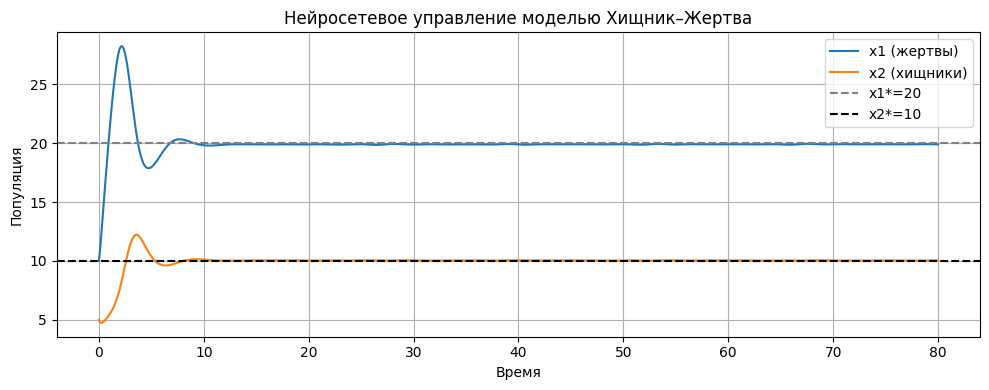

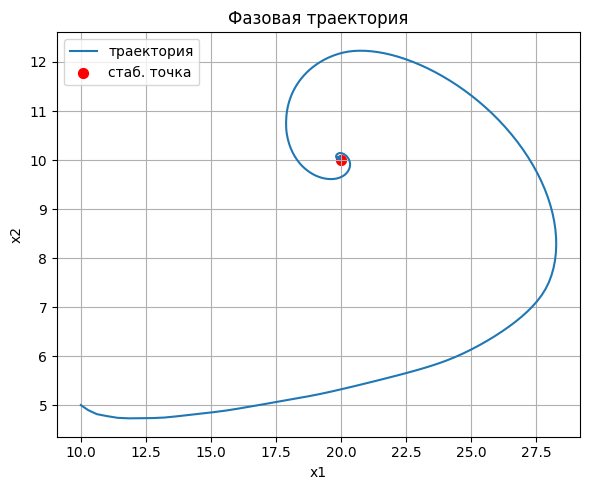

In [18]:
# — популяции —
plt.figure(figsize=(10,4))
plt.plot(t, x1, label='x1 (жертвы)')
plt.plot(t, x2, label='x2 (хищники)')
plt.axhline(x_star[0], linestyle='--', color='gray',  label=f'x1*={x_star[0]:.0f}')
plt.axhline(x_star[1], linestyle='--', color='black', label=f'x2*={x_star[1]:.0f}')
plt.title("Нейросетевое управление моделью Хищник–Жертва")
plt.xlabel("Время")
plt.ylabel("Популяция")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# — фазовая траектория —
plt.figure(figsize=(6,5))
plt.plot(x1, x2, label='траектория')
plt.scatter(*x_star, color='red', s=50, label='стаб. точка')
plt.title("Фазовая траектория")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()